对比GRU，增加一个隐藏变量C，I决定当前隐藏变量C的保留程度，F决定前一个C的保留程度，I和F类似于GRU中的R的独立版本，分别控制新旧记忆，可以都不要，也可以都保留，所以C是一个$(-2, 2)$范围的值，经过tanh得到H，范围为$(-1, 1)$，最终输出仍然由H决定

$$
\begin{aligned}
I_t &= \sigma(X_t W_{xi} + H_{t-1} W_{hi} + b_i) \\
F_t &= \sigma(X_t W_{xf} + H_{t-1} W_{hf} + b_f) \\
O_t &= \sigma(X_t W_{xo} + H_{t-1} W_{ho} + b_o) \\
\tilde{C}_t &= \tanh(X_t W_{xc} + H_{t-1} W_{hc} + b_c) \\
C_t &= F_t \circ C_{t-1} + I_t \circ \tilde{C}_t \\
H_t &= O_t \circ \tanh(C_t)
\end{aligned}
$$

![2025-07-13 21-15-32 的屏幕截图.png](<attachment:2025-07-13 21-15-32 的屏幕截图.png>)
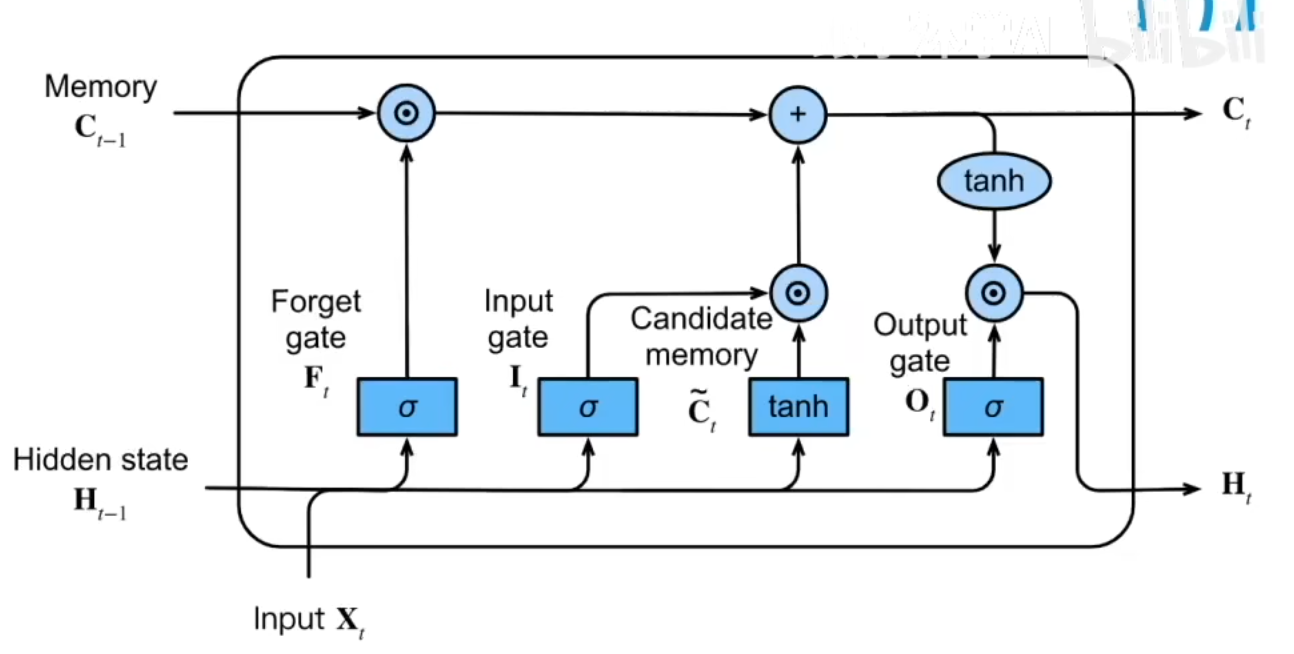

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()
    W_xf, W_hf, b_f = three()
    W_xo, W_ho, b_o = three()
    W_xc, W_hc, b_c = three()

    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, 
              W_xc, W_hc, b_c, W_xo, W_ho, b_o, 
              W_hq, b_q]
    
    for param in params:
        param.requires_grad_(True)
    
    return params

有两个“隐藏”状态，H和C

In [4]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), 
            torch.zeros((batch_size, num_hiddens), device=device))

In [7]:
def lstm(inputs, state, params):
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xc, W_hc, b_c, W_xo, W_ho, b_o, W_hq, b_q = params
    (H, C) = state

    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda

        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)

    return torch.cat(outputs, dim=0), (H, C)

困惑度1.1, 60935.1 词元/秒 cuda:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


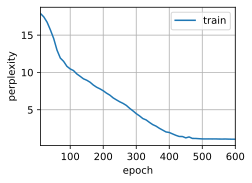

In [11]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()

num_epochs, lr = 600, 1
model = d2l.RNNModelScrath(len(vocab), num_hiddens, device, get_lstm_params,
                           init_gru_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

困惑度1.0, 289456.2 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


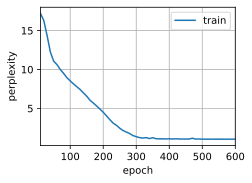

In [12]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, num_inputs)
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)